# Random Forest Regression to Forecast Merchant Monthly Revenue
This notebook will cover the RF modelling employed to create an overall merchant ranking by their projected monthly revenue.

In [1]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


spark = (
    SparkSession.builder.appName("RF Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "16g")  # Increase driver memory
    .config("spark.executor.memory", "16g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/28 15:45:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark.catalog.clearCache()


In [3]:
# Read transaction file
transactions = spark.read.parquet('../data/curated/flagged_fraud')
transactions = transactions.filter(F.col("is_fraud") != True)

In [4]:
transactions.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- year_week: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: double (nullable = true)
 |-- name_consumer: string (nullable = true)
 |-- address_consumer: string (nullable = true)
 |-- state_consumer: string (nullable = true)
 |-- postcode_consumer: integer (nullable = true)
 |-- gender_consumer: string (nullable = true)
 |-- name_merchant: string (nullable = true)
 |-- fraud_probability_merchant: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_month_year: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)
 |-- unemployment_rate: string (nullable = true)
 |-- consumer_weekly_transaction: long (nullable = true)
 |-- merchant_weekly_transaction: long (nullable = true)
 |-- is_

### Feature Engineering

In [5]:
# Aggregating monthly revenue for each merchant
monthly_revenue_df = transactions.groupBy('merchant_abn', 'order_month_year').agg(
    F.sum('dollar_value').alias('monthly_revenue'),
    F.count('order_id').alias('transaction_count'),
    F.avg('fraud_probability_merchant').alias('avg_fraud_probability_merchant'),
    F.first('name_merchant').alias('merchant_name'),
    F.avg('take_rate').alias('avg_take_rate'),
    F.first('revenue_band').alias('revenue_band'),
    F.first('merchant_category').alias('merchant_category')
)
    
# Aggregating consumer-level features (most common state and gender for each merchant)

# Most common consumer state per merchant
consumer_state_mode = transactions.groupBy('merchant_abn', 'state_consumer').count() \
    .withColumn('row_num', F.row_number().over(Window.partitionBy('merchant_abn').orderBy(F.desc('count')))) \
    .filter(F.col('row_num') == 1) \
    .select('merchant_abn', 'state_consumer')

# Most common consumer gender per merchant
consumer_gender_mode = transactions.groupBy('merchant_abn', 'gender_consumer').count() \
    .withColumn('row_num', F.row_number().over(Window.partitionBy('merchant_abn').orderBy(F.desc('count')))) \
    .filter(F.col('row_num') == 1) \
    .select('merchant_abn', 'gender_consumer')

# Average Unemployment Rate per Merchant Month-Year
transactions = transactions.withColumn("unemployment_rate_numeric", F.col("unemployment_rate").cast("float"))

unemployment_agg = transactions.groupBy('merchant_abn', 'order_month_year').agg(
    F.avg('unemployment_rate_numeric').alias('avg_unemployment_rate')
)

In [6]:
# Joining Datasets
monthly_revenue_df = monthly_revenue_df.join(consumer_state_mode, on='merchant_abn', how='left') \
                                      .join(consumer_gender_mode, on='merchant_abn', how='left')

# Join with unemployment data on both 'merchant_abn' and 'order_month_year'
monthly_revenue_df = monthly_revenue_df.join(unemployment_agg, on=['merchant_abn', 'order_month_year'], how='left')

# Show the final dataframe
monthly_revenue_df.show(5)

+------------+----------------+------------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+
|merchant_abn|order_month_year|   monthly_revenue|transaction_count|avg_fraud_probability_merchant|       merchant_name|      avg_take_rate|revenue_band|   merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|
+------------+----------------+------------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+
| 10023283211|          Feb-22| 48572.88260819351|              215|             56.06942278917232|       Felis Limited|0.18000000715255737|           e|furniture, home f...|           NSW|           Male|    71.28418544059576|
| 10023283211|          Oct-21|  70276.0243256525|              357|            55.89265

In [7]:
# Checking for Missing Values
nulls = monthly_revenue_df.agg(
    *(F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in monthly_revenue_df.columns)
)

# Show the result
nulls.show()

24/09/28 15:45:50 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------------+----------------+---------------+-----------------+------------------------------+-------------+-------------+------------+-----------------+--------------+---------------+---------------------+
|merchant_abn|order_month_year|monthly_revenue|transaction_count|avg_fraud_probability_merchant|merchant_name|avg_take_rate|revenue_band|merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|
+------------+----------------+---------------+-----------------+------------------------------+-------------+-------------+------------+-----------------+--------------+---------------+---------------------+
|           0|               0|              0|                0|                             0|            0|            0|           0|                0|             0|              0|                    0|
+------------+----------------+---------------+-----------------+------------------------------+-------------+-------------+------------+-----------------+---------

In [8]:
# Creating lag features to include previous month's revenue
window_spec = Window.partitionBy('merchant_abn').orderBy('order_month_year')

# Lagging features: Previous month's revenue
monthly_revenue_df = monthly_revenue_df.withColumn(
    'previous_month_revenue', F.lag('monthly_revenue', 1).over(window_spec)
)

# Calculate revenue growth (percentage change)
monthly_revenue_df = monthly_revenue_df.withColumn(
    'revenue_growth',
    F.when(F.col('previous_month_revenue') > 0, 
           (F.col('monthly_revenue') - F.col('previous_month_revenue')) / F.col('previous_month_revenue'))
    .otherwise(F.lit(0))  # Fill with 0 if there is no previous revenue
)

# Fill NA values for first month with 0 (no previous data available)
monthly_revenue_df = monthly_revenue_df.fillna({'previous_month_revenue': 0, 'revenue_growth': 0})


monthly_revenue_df = monthly_revenue_df.fillna(0)  # Filling NA values for first month
monthly_revenue_df.show(5)

+------------+----------------+------------------+-----------------+------------------------------+-------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+
|merchant_abn|order_month_year|   monthly_revenue|transaction_count|avg_fraud_probability_merchant|merchant_name|      avg_take_rate|revenue_band|   merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|previous_month_revenue|      revenue_growth|
+------------+----------------+------------------+-----------------+------------------------------+-------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+
| 10023283211|          Apr-21| 9221.405806871098|               47|             56.03849374950703|Felis Limited|0.18000000715255737|           e|furniture, home f...|           NSW|           Male|    74.

### Data Preparation

In [9]:
from pyspark.ml.feature import StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# StringIndexing categorical columns (merchant_tags, consumer_state, gender_consumer)
indexers = [
    StringIndexer(inputCol='state_consumer', outputCol='state_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='gender_consumer', outputCol='gender_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='merchant_category', outputCol='category_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='revenue_band', outputCol='revenue_band_indexed', handleInvalid='keep')
]

# OneHotEncoding indexed columns
encoders = [
    OneHotEncoder(inputCol='state_consumer_indexed', outputCol='state_consumer_encoded'),
    OneHotEncoder(inputCol='gender_consumer_indexed', outputCol='gender_consumer_encoded'),
    OneHotEncoder(inputCol='category_indexed', outputCol='category_encoded'),
    OneHotEncoder(inputCol='revenue_band_indexed', outputCol='revenue_band_encoded')
]

feature_cols = [
        'monthly_revenue', 'transaction_count', 'avg_fraud_probability_merchant', 'avg_unemployment_rate',
        'state_consumer_encoded', 'gender_consumer_encoded', 'revenue_growth', 'category_encoded', 'revenue_band_encoded',
        'avg_take_rate'
    ]

# VectorAssembler to combine numeric features into a single feature vector
assembler = VectorAssembler(inputCols= feature_cols, outputCol='features')

# Standardizing the numeric features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

# Fit the pipeline to the dataset
model_pipeline = pipeline.fit(monthly_revenue_df)

final_df = model_pipeline.transform(monthly_revenue_df)

final_df.select('merchant_abn', 'order_month_year', 'scaled_features').show(5)


+------------+----------------+--------------------+
|merchant_abn|order_month_year|     scaled_features|
+------------+----------------+--------------------+
| 10023283211|          Apr-21|(46,[0,1,2,3,4,11...|
| 10023283211|          Aug-21|(46,[0,1,2,3,4,11...|
| 10023283211|          Dec-21|(46,[0,1,2,3,4,11...|
| 10023283211|          Feb-22|(46,[0,1,2,3,4,11...|
| 10023283211|          Jan-22|(46,[0,1,2,3,4,11...|
+------------+----------------+--------------------+
only showing top 5 rows



### Training Model

In [10]:
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

In [11]:
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='monthly_revenue', maxBins=32, maxDepth=10)
rf_model = rf.fit(train_data)
rf_model.write().overwrite().save("random_forest_model") # Save Model

# Make predictions on the test data
predictions = rf_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='rmse')

# Root Mean Squared Error (RMSE)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared
r2_evaluator = RegressionEvaluator(labelCol='monthly_revenue', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(predictions)
print(f"R-squared: {r2}")

predictions.select('merchant_abn', 'order_month_year', 'monthly_revenue', 'revenue_growth','prediction').show(5)

24/09/28 15:46:21 WARN DAGScheduler: Broadcasting large task binary with size 1466.7 KiB
24/09/28 15:46:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Root Mean Squared Error (RMSE): 31107.66442877631


R-squared: 0.8954946508288283


+------------+----------------+------------------+-------------------+------------------+
|merchant_abn|order_month_year|   monthly_revenue|     revenue_growth|        prediction|
+------------+----------------+------------------+-------------------+------------------+
| 10023283211|          Dec-21| 66067.74432316715| 3.1795241652322175| 83247.09556261399|
| 10023283211|          Jun-21|11078.327301762965|0.10239164872676397|11251.333849285797|
| 10023283211|          May-21|11953.898144671877| 0.3170441527012353| 12975.26306418207|
| 10187291046|          Aug-21|1059.7535269884397|  5.158034850430842| 2217.083600903298|
| 10187291046|          Mar-21|  750.345554053667|  1.864485833032831|1721.8423690302916|
+------------+----------------+------------------+-------------------+------------------+
only showing top 5 rows



## Predicting Future Monthly Revenue

In [12]:
from pyspark.sql.types import DateType
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Step 1: Parse the order_month_year column to a proper date format
monthly_revenue_df = monthly_revenue_df.withColumn(
    'order_month_year_date', F.to_date(F.concat(F.lit('01-'), F.col('order_month_year')), 'dd-MMM-yy')
)

# Get the most recent month per merchant
window_spec = Window.partitionBy('merchant_abn').orderBy(F.desc('order_month_year_date'))
latest_merchant_data = monthly_revenue_df.withColumn('row_num', F.row_number().over(window_spec)) \
                                         .filter(F.col('row_num') == 1) \
                                         .drop('row_num')

In [13]:
next_month = 'Aug-24'
future_month_df = spark.createDataFrame([(next_month,)], ['future_order_month_year'])
future_data = latest_merchant_data.crossJoin(future_month_df)

In [14]:
future_data.show(5)

+------------+----------------+-----------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+---------------------+-----------------------+
|merchant_abn|order_month_year|  monthly_revenue|transaction_count|avg_fraud_probability_merchant|       merchant_name|      avg_take_rate|revenue_band|   merchant_category|state_consumer|gender_consumer|avg_unemployment_rate|previous_month_revenue|      revenue_growth|order_month_year_date|future_order_month_year|
+------------+----------------+-----------------+-----------------+------------------------------+--------------------+-------------------+------------+--------------------+--------------+---------------+---------------------+----------------------+--------------------+---------------------+-----------------------+
| 10023283211|          Feb-22|48572.88260819351|

In [15]:
future_data = model_pipeline.transform(future_data)
future_data = rf_model.transform(future_data)
future_predictions = future_data.select('merchant_abn', 'merchant_name', 'merchant_category', 'future_order_month_year', 'prediction')
future_predictions = future_predictions.withColumnRenamed('prediction', 'projected_revenue')
future_predictions.show(5)

+------------+--------------------+--------------------+-----------------------+------------------+
|merchant_abn|       merchant_name|   merchant_category|future_order_month_year| projected_revenue|
+------------+--------------------+--------------------+-----------------------+------------------+
| 10023283211|       Felis Limited|furniture, home f...|                 Aug-24| 41369.39880578193|
| 10142254217|Arcu Ac Orci Corp...|cable, satellite,...|                 Aug-24|16670.300162992433|
| 10187291046|Ultricies Digniss...|watch, clock, and...|                 Aug-24|3833.4610267711155|
| 10192359162| Enim Condimentum PC|music shops - mus...|                 Aug-24|11233.457948546351|
| 10206519221|       Fusce Company|gift, card, novel...|                 Aug-24| 8187.578323841737|
+------------+--------------------+--------------------+-----------------------+------------------+
only showing top 5 rows



In [16]:
RF_predictions = future_predictions.orderBy(F.col('projected_revenue').desc())

# Show the top 10 merchants by predicted revenue
RF_predictions.show(10)

+------------+--------------------+--------------------+-----------------------+------------------+
|merchant_abn|       merchant_name|   merchant_category|future_order_month_year| projected_revenue|
+------------+--------------------+--------------------+-----------------------+------------------+
| 90543168331|Phasellus Dapibus...|furniture, home f...|                 Aug-24|  584765.946289495|
| 84703983173|     Amet Consulting|computer programm...|                 Aug-24|  570301.576584075|
| 43186523025|Lorem Ipsum Sodal...|florists supplies...|                 Aug-24| 558072.5489561955|
| 21772962346|Purus Gravida Sag...|florists supplies...|                 Aug-24| 538759.0271418772|
| 38090089066|Interdum Feugiat ...|furniture, home f...|                 Aug-24| 524404.0714474998|
| 35909341340|Arcu Sed Eu Incor...|computer programm...|                 Aug-24|491570.47426786897|
| 49505931725|Suspendisse Ac As...|digital goods: bo...|                 Aug-24| 489239.8138946534|


## Export Ranked Data

In [17]:
RF_predictions = RF_predictions.limit(100)
#RF_predictions.write.parquet('../data/curated/RF_ranking')

## Evaluating Model

In [18]:
importances = rf_model.featureImportances
importance_values = importances.toArray()

In [19]:
# Fit the StringIndexer on your data
indexers = [
    StringIndexer(inputCol='state_consumer', outputCol='state_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='gender_consumer', outputCol='gender_consumer_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='merchant_category', outputCol='category_indexed', handleInvalid='keep'),
    StringIndexer(inputCol='revenue_band', outputCol='revenue_band_indexed', handleInvalid='keep')
]

indexer_models = [indexer.fit(monthly_revenue_df) for indexer in indexers]

# Get the actual number of categories for each categorical column
for indexer_model in indexer_models:
    print(f"Column: {indexer_model.getInputCol()} - Number of Categories: {len(indexer_model.labels)}")

Column: state_consumer - Number of Categories: 7
Column: gender_consumer - Number of Categories: 3
Column: merchant_category - Number of Categories: 25
Column: revenue_band - Number of Categories: 5


In [20]:
vec_assembler_stage = model_pipeline.stages[-2]
encoded_feature_cols = vec_assembler_stage.getInputCols()

onehot_encoded_sizes = {
    'state_consumer_encoded': 7,  # Update with the actual number of categories
    'gender_consumer_encoded': 3,  # Update with the actual number of categories
    'category_encoded': 25,  # Update with actual number
    'revenue_band_encoded':5  # Update with actual number
}

# Flatten the encoded features (e.g., one-hot encoded columns)
expanded_feature_cols = []
for col in encoded_feature_cols:
    if col in onehot_encoded_sizes:
        expanded_feature_cols.extend([f'{col}_{i}' for i in range(onehot_encoded_sizes[col])])
    else:
        expanded_feature_cols.append(col)

In [21]:
feature_importance_df = pd.DataFrame({
    'Feature': expanded_feature_cols,
    'Importance': importance_values
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

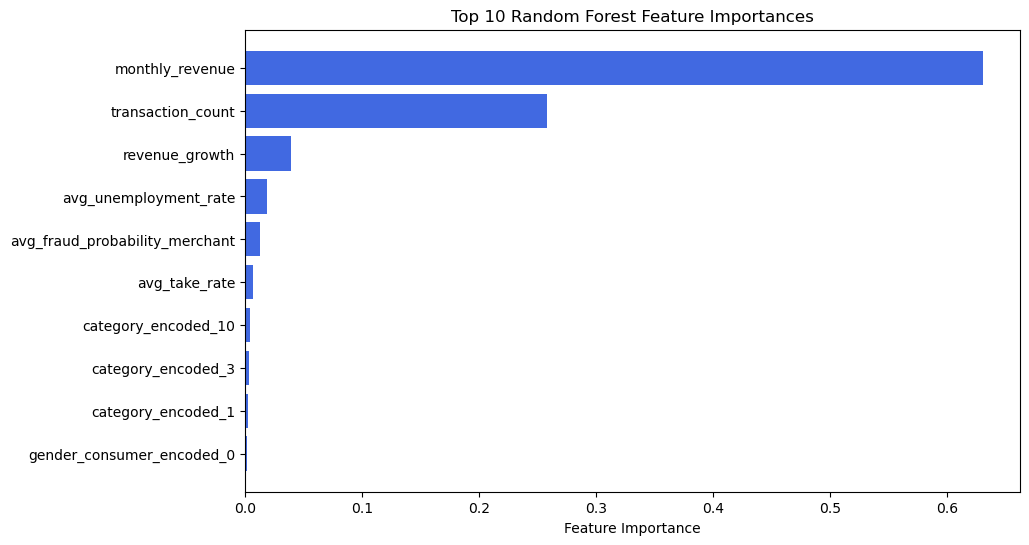

In [22]:
import matplotlib.pyplot as plt

# Sort the features by importance and take the top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='royalblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Random Forest Feature Importances')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

In [25]:
# Explore which category is referred to in feature importance
category_indexer_model = indexer_models[2]

# Get the list of categories
category_labels = category_indexer_model.labels

print(f"Category for category_encoded_10: {category_labels[10]}")
print(f"Category for category_encoded_3: {category_labels[2]}")
print(f"Category for category_encoded_1: {category_labels[1]}")
print(f"Category for category_encoded_0: {category_labels[0]}")


Category for category_encoded_10: furniture, home furnishings and equipment shops, and manufacturers, except appliances
Category for category_encoded_3: computer programming , data processing, and integrated systems design services
Category for category_encoded_1: digital goods: books, movies, music
Category for category_encoded_0: tent and awning shops


In [26]:
spark.stop()